In [1]:
import os
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

In [2]:
DATASET_ROOT = "wikiart"

train_artist = pd.read_csv("data/artist_train.csv")
val_artist = pd.read_csv("data/artist_val.csv")

train_genre = pd.read_csv("data/genre_train.csv")
train_genre = train_genre.sample(frac=0.5, random_state=42).reset_index(drop=True)

val_genre = pd.read_csv("data/genre_val.csv")
val_genre = val_genre.sample(frac=0.5, random_state=42).reset_index(drop=True)

train_style = pd.read_csv("data/style_train.csv")
train_style = train_style.sample(frac=0.3, random_state=42).reset_index(drop=True)

val_style = pd.read_csv("data/style_val.csv")
val_style = val_style.sample(frac=0.3, random_state=42).reset_index(drop=True)

print("Artist Train Sample:")
print(train_artist.head(), "\n")

print("Genre Train Sample:")
print(train_genre.head(), "\n")

print("Style Train Sample:")
print(train_style.head(), "\n")


Artist Train Sample:
                                                Path  Label
0  Realism/vincent-van-gogh_pine-trees-in-the-fen...     22
1  Baroque/rembrandt_the-angel-appearing-to-the-s...     20
2  Post_Impressionism/paul-cezanne_portrait-of-th...     16
3  Impressionism/pierre-auguste-renoir_young-girl...     17
4       Romanticism/ivan-aivazovsky_morning-1851.jpg      9 

Genre Train Sample:
                                                Path  Label
0  Impressionism/alfred-sisley_by-way-of-the-old-...      4
1  Mannerism_Late_Renaissance/titian_youth-with-d...      6
2              Realism/aleksey-savrasov_spring-1.jpg      4
3  Art_Nouveau_Modern/boris-kustodiev_in-the-box-...      2
4  Art_Nouveau_Modern/raphael-kirchner_love-flowe...      2 

Style Train Sample:
                                                Path  Label
0  Baroque/annibale-carracci_hommage-to-diana-160...      4
1  Symbolism/nicholas-roerich_sketch-for-tale-of-...     24
2  Realism/charles-hermans_at-the-m

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [4]:
class WikiArtDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.valid_data = []

        for idx in range(len(dataframe)):
            img_path, label = dataframe.iloc[idx]
            full_path = os.path.join(root_dir, img_path)

            if os.path.exists(full_path):  
                self.valid_data.append((full_path, label))
            else:
                print(f"Skipping missing file: {full_path}")

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img_path, label = self.valid_data[idx]  
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_artist_dataset = WikiArtDataset(train_artist, DATASET_ROOT, transform=train_transforms)
val_artist_dataset = WikiArtDataset(val_artist, DATASET_ROOT, transform=val_transforms)

train_genre_dataset = WikiArtDataset(train_genre, DATASET_ROOT, transform=train_transforms)
val_genre_dataset = WikiArtDataset(val_genre, DATASET_ROOT, transform=val_transforms)

train_style_dataset = WikiArtDataset(train_style, DATASET_ROOT, transform=train_transforms)
val_style_dataset = WikiArtDataset(val_style, DATASET_ROOT, transform=val_transforms)

print(f"Artist Train Dataset: {len(train_artist_dataset)} images")
print(f"Genre Train Dataset: {len(train_genre_dataset)} images")
print(f"Style Train Dataset: {len(train_style_dataset)} images")


Skipping missing file: wikiart\Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg
Skipping missing file: wikiart\Baroque/rembrandt_woman-standing-with-raised-hands.jpg
Skipping missing file: wikiart\Baroque/rembrandt_woman-standing-with-raised-hands.jpg
Skipping missing file: wikiart\Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg
Skipping missing file: wikiart\Baroque/rembrandt_woman-standing-with-raised-hands.jpg
Artist Train Dataset: 13344 images
Genre Train Dataset: 22751 images
Style Train Dataset: 17106 images


In [5]:
BATCH_SIZE = 32

train_artist_loader = DataLoader(train_artist_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_artist_loader = DataLoader(val_artist_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_genre_loader = DataLoader(train_genre_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_genre_loader = DataLoader(val_genre_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_style_loader = DataLoader(train_style_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_style_loader = DataLoader(val_style_dataset, batch_size=BATCH_SIZE, shuffle=False)

data_iter = iter(train_style_loader)
sample_images, sample_labels = next(data_iter)

print(f"Loaded batch of {sample_images.shape} images and labels.")


Loaded batch of torch.Size([32, 3, 128, 128]) images and labels.


In [6]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True) 
        self.feature_extractor = nn.Sequential(*list(mobilenet.children())[:-1]) 

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), x.size(1), -1)
        return x


In [7]:
class CNNRNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNRNNClassifier, self).__init__()
        self.cnn = CNNFeatureExtractor()
        self.rnn = nn.GRU(input_size=1280, hidden_size=256, num_layers=1, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1, x.size(1))
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [8]:
num_classes_style = len(train_style["Label"].unique()) 
num_classes_artist = len(train_artist["Label"].unique())
num_classes_genre = len(train_genre["Label"].unique())

In [9]:
print(num_classes_style,num_classes_artist,num_classes_genre)

27 23 10


In [10]:
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, file):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "val_loss": val_loss,
        "val_acc": val_acc,
    }
    torch.save(checkpoint, file)
    print(f"Saved at epoch {epoch+1} (Accuracy: {val_acc:.2f}%)")

def load_checkpoint(model, optimizer, file):
    if os.path.exists(file):
        checkpoint = torch.load(file)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        print(f"Resuming training from epoch {checkpoint['epoch']+1} (Last Accuracy: {checkpoint['val_acc']:.2f}%)")
        return checkpoint["epoch"], checkpoint["val_loss"], checkpoint["val_acc"]
    return 0, float("inf"), 0.0 


In [11]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / labels.size(0)

In [12]:
def train_model(model, train_loader, val_loader, optimizer, criterion, checkpoint_file, num_epochs=30, patience=10):
    device = "cuda" 
    model.to(device)

    start_epoch, best_val_loss, best_val_acc = load_checkpoint(model, optimizer, checkpoint_file) 
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs): 
        model.train()
        running_loss = 0.0
        correct, total = 0, 0 
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=running_loss / len(train_loader))

        train_loss = running_loss / len(train_loader)
        train_acc = (correct / total) * 100

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = (correct / total) * 100

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, val_loss, val_acc, checkpoint_file)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Stopping training.")
                break

    print(f"Validation Accuracy: {best_val_acc:.2f}%")


In [13]:
criterion = nn.CrossEntropyLoss()
BATCH_SIZE = 4

In [28]:
style_model = CNNRNNClassifier(num_classes_style)
optimizer_style = torch.optim.Adam(style_model.parameters(), lr=0.0001)
train_model(style_model, train_style_loader, val_style_loader, optimizer_style, criterion,"style.pth")
torch.save(style_model,"style_model.pth")

Epoch 6/30:  45%|████▌     | 242/535 [06:21<08:23,  1.72s/it, loss=0.518]c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 6/30: 100%|██████████| 535/535 [14:03<00:00,  1.58s/it, loss=1.18] 


Epoch 6: Train Loss: 1.1763, Train Acc: 61.21% | Val Loss: 1.6013, Val Acc: 48.72%
Saved at epoch 6 (Accuracy: 48.72%)


Epoch 7/30: 100%|██████████| 535/535 [1:53:03<00:00, 12.68s/it, loss=1.08]       


Epoch 7: Train Loss: 1.0760, Train Acc: 64.12% | Val Loss: 1.6041, Val Acc: 49.99%
Saved at epoch 7 (Accuracy: 49.99%)


Epoch 8/30: 100%|██████████| 535/535 [11:46<00:00,  1.32s/it, loss=0.99] 


Epoch 8: Train Loss: 0.9899, Train Acc: 67.00% | Val Loss: 1.6089, Val Acc: 49.92%


Epoch 9/30: 100%|██████████| 535/535 [10:02<00:00,  1.13s/it, loss=0.901]


Epoch 9: Train Loss: 0.9009, Train Acc: 70.17% | Val Loss: 1.6619, Val Acc: 48.32%


Epoch 10/30: 100%|██████████| 535/535 [09:51<00:00,  1.11s/it, loss=0.815]


Epoch 10: Train Loss: 0.8151, Train Acc: 72.76% | Val Loss: 1.6777, Val Acc: 49.92%


Epoch 11/30: 100%|██████████| 535/535 [10:16<00:00,  1.15s/it, loss=0.744]


Epoch 11: Train Loss: 0.7442, Train Acc: 75.48% | Val Loss: 1.7651, Val Acc: 49.09%


Epoch 12/30: 100%|██████████| 535/535 [10:09<00:00,  1.14s/it, loss=0.669]


Epoch 12: Train Loss: 0.6690, Train Acc: 77.72% | Val Loss: 1.8087, Val Acc: 48.42%


Epoch 13/30: 100%|██████████| 535/535 [10:17<00:00,  1.15s/it, loss=0.609] 


Epoch 13: Train Loss: 0.6088, Train Acc: 79.98% | Val Loss: 1.8486, Val Acc: 47.88%


Epoch 14/30: 100%|██████████| 535/535 [10:12<00:00,  1.14s/it, loss=0.552]


Epoch 14: Train Loss: 0.5517, Train Acc: 81.64% | Val Loss: 1.8859, Val Acc: 49.18%


Epoch 15/30: 100%|██████████| 535/535 [13:06<00:00,  1.47s/it, loss=0.506]  


Epoch 15: Train Loss: 0.5058, Train Acc: 83.20% | Val Loss: 1.9403, Val Acc: 48.35%
Stopping training.
Validation Accuracy: 49.99%


In [12]:
artist_model = CNNRNNClassifier(num_classes_artist)
optimizer_artist = torch.optim.Adam(artist_model.parameters(), lr=0.0001)
train_model(artist_model, train_artist_loader, val_artist_loader, optimizer_artist, criterion,"artist.pth")
torch.save(artist_model,"artist_model.pth")

Epoch 1/30: 100%|██████████| 417/417 [09:13<00:00,  1.33s/it, loss=1.89] 


📊 Epoch 1: Train Loss: 1.8926, Train Acc: 46.74% | Val Loss: 1.2791, Val Acc: 63.62%
✅ Saved checkpoint at epoch 1 (Accuracy: 63.62%)


Epoch 2/30: 100%|██████████| 417/417 [06:35<00:00,  1.05it/s, loss=1.16] 


📊 Epoch 2: Train Loss: 1.1568, Train Acc: 66.20% | Val Loss: 1.0094, Val Acc: 70.72%
✅ Saved checkpoint at epoch 2 (Accuracy: 70.72%)


Epoch 3/30: 100%|██████████| 417/417 [06:32<00:00,  1.06it/s, loss=0.903]


📊 Epoch 3: Train Loss: 0.9028, Train Acc: 73.46% | Val Loss: 0.8907, Val Acc: 73.75%
✅ Saved checkpoint at epoch 3 (Accuracy: 73.75%)


Epoch 4/30: 100%|██████████| 417/417 [06:36<00:00,  1.05it/s, loss=0.75] 


📊 Epoch 4: Train Loss: 0.7497, Train Acc: 77.83% | Val Loss: 0.8527, Val Acc: 75.74%
✅ Saved checkpoint at epoch 4 (Accuracy: 75.74%)


Epoch 5/30: 100%|██████████| 417/417 [06:38<00:00,  1.05it/s, loss=0.624]


📊 Epoch 5: Train Loss: 0.6240, Train Acc: 81.03% | Val Loss: 0.8039, Val Acc: 76.50%
✅ Saved checkpoint at epoch 5 (Accuracy: 76.50%)


Epoch 6/30: 100%|██████████| 417/417 [06:34<00:00,  1.06it/s, loss=0.544] 


📊 Epoch 6: Train Loss: 0.5443, Train Acc: 83.67% | Val Loss: 0.7630, Val Acc: 77.76%
✅ Saved checkpoint at epoch 6 (Accuracy: 77.76%)


Epoch 7/30: 100%|██████████| 417/417 [06:35<00:00,  1.05it/s, loss=0.467]


📊 Epoch 7: Train Loss: 0.4673, Train Acc: 85.83% | Val Loss: 0.7841, Val Acc: 77.55%


Epoch 8/30: 100%|██████████| 417/417 [06:36<00:00,  1.05it/s, loss=0.41]  


📊 Epoch 8: Train Loss: 0.4099, Train Acc: 87.48% | Val Loss: 0.7854, Val Acc: 77.04%


Epoch 9/30: 100%|██████████| 417/417 [06:34<00:00,  1.06it/s, loss=0.354] 


📊 Epoch 9: Train Loss: 0.3542, Train Acc: 89.37% | Val Loss: 0.7783, Val Acc: 78.60%
✅ Saved checkpoint at epoch 9 (Accuracy: 78.60%)


Epoch 10/30: 100%|██████████| 417/417 [06:52<00:00,  1.01it/s, loss=0.299] 


📊 Epoch 10: Train Loss: 0.2990, Train Acc: 90.89% | Val Loss: 0.7834, Val Acc: 78.13%
⏹️ Early stopping triggered. Stopping training.
✅ Training complete! Best Validation Accuracy: 78.60%


In [21]:
genre_model = CNNRNNClassifier(num_classes_genre)
optimizer_genre = torch.optim.Adam(genre_model.parameters(), lr=0.0001)
train_model(genre_model, train_genre_loader, val_genre_loader, optimizer_genre, criterion,"genre.pth")
torch.save(genre_model,"genre_model.pth")

Epoch 13/30:  75%|███████▌  | 536/711 [28:42<10:30,  3.60s/it, loss=0.365] c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 13/30: 100%|██████████| 711/711 [41:19<00:00,  3.49s/it, loss=0.485]


Epoch 13: Train Loss: 0.4847, Train Acc: 82.65% | Val Loss: 0.9076, Val Acc: 71.81%
Saved at epoch 13 (Accuracy: 71.81%)


Epoch 14/30: 100%|██████████| 711/711 [24:23<00:00,  2.06s/it, loss=0.457] 


Epoch 14: Train Loss: 0.4569, Train Acc: 84.00% | Val Loss: 0.9799, Val Acc: 70.07%


Epoch 15/30: 100%|██████████| 711/711 [15:29<00:00,  1.31s/it, loss=0.439] 


Epoch 15: Train Loss: 0.4391, Train Acc: 84.48% | Val Loss: 0.9695, Val Acc: 70.78%


Epoch 16/30: 100%|██████████| 711/711 [20:53<00:00,  1.76s/it, loss=0.416] 


Epoch 16: Train Loss: 0.4162, Train Acc: 85.39% | Val Loss: 1.0010, Val Acc: 70.09%


Epoch 17/30: 100%|██████████| 711/711 [18:15<00:00,  1.54s/it, loss=0.402] 


Epoch 17: Train Loss: 0.4017, Train Acc: 85.86% | Val Loss: 1.0011, Val Acc: 70.24%
Stopping training.
Validation Accuracy: 71.81%


In [14]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_saved_model(model_file, val_loader, class_names, device="cuda"):

    model = torch.load(model_file, map_location=device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, f1

def get_class_names(train_dataset):
    class_labels = train_dataset.dataframe["Label"].unique()
    class_labels = sorted(class_labels)
    return class_labels


C:\Users\goyal\AppData\Local\Temp\ipykernel_14408\3440637939.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Accuracy: 78.13%
Precision: 78.27%
Recall: 78.13%
F1-Score: 77.99%


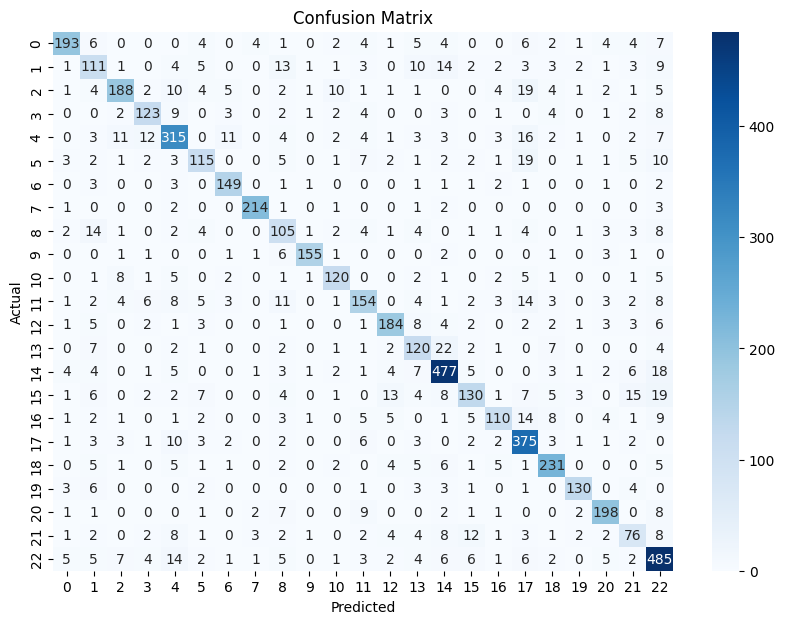

(0.7812828601472135, 0.782726120141294, 0.7812828601472135, 0.7798672940989553)

In [ ]:
class_names = get_class_names(train_artist_dataset)
evaluate_saved_model("artist_model.pth", val_artist_loader, class_names)

C:\Users\goyal\AppData\Local\Temp\ipykernel_1792\2216493298.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Accuracy: 70.24%
Precision: 70.81%
Recall: 70.24%
F1-Score: 70.34%


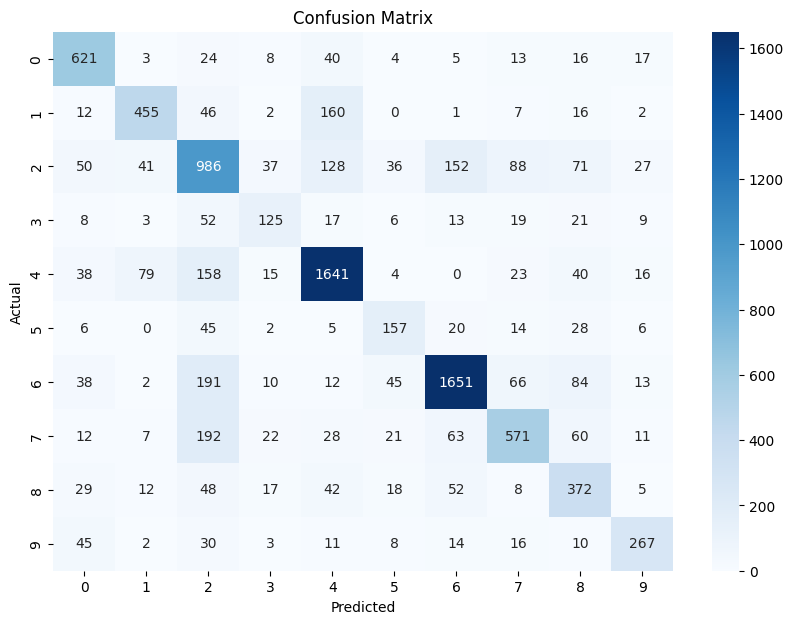

(0.7024420274984609,
 0.7081406189516692,
 0.7024420274984609,
 0.7033847946982348)

In [17]:
class_names = get_class_names(train_genre_dataset)
evaluate_saved_model("genre_model.pth", val_genre_loader, class_names)

C:\Users\goyal\AppData\Local\Temp\ipykernel_11248\2216493298.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Accuracy: 48.35%
Precision: 49.09%
Recall: 48.35%
F1-Score: 48.07%


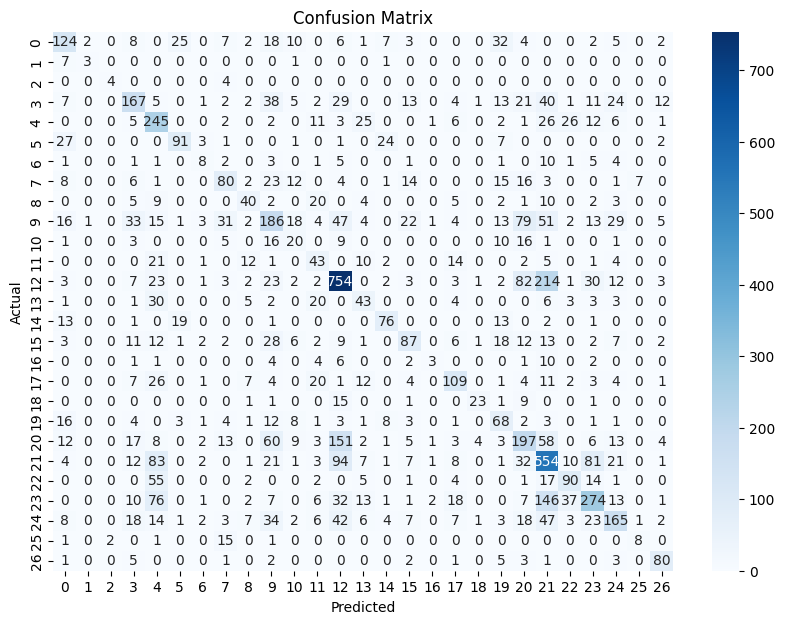

(0.48348348348348347,
 0.4908798542900188,
 0.48348348348348347,
 0.4806882139286169)

In [15]:
class_names = get_class_names(train_style_dataset)
evaluate_saved_model("style_model.pth",val_style_loader, class_names)